In [1]:
import numpy as np
import pandas as pd
import os
import lightgbm as lgb
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import random

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from collections import Counter

from google.colab import drive
from datetime import datetime

In [2]:
drive.mount('/content/drive')
root_path = 'drive/My Drive/KU/Robin_lab_project' 
os.chdir(root_path)

Mounted at /content/drive


In [3]:
# Set details for saving the plots
DIRECTORY = "Plots/new_impl_2512_0.5/"
FILENAME = "rank_negFiltered_atleast2max_negRatio_0.5_v2"

# Data exploration

In [ ]:
# Load data 
profiles_all = pd.read_csv(f"Data/ML_input/profiles_{FILENAME}.csv")
metadata_all = pd.read_csv(f"Data/ML_input/metadata_{FILENAME}.csv")

X = profiles_all.drop("label", axis=1)
X = StandardScaler().fit_transform(X)
y = profiles_all["label"]

print(X.shape)
print(y.shape)

### PCA


In [ ]:
#  PCA plot
def multi_plot_pca(x, y, 
                   nrows=2, xlim=(-23,43), ylim=(-23,23),
                   figsize=(12,7), top=0.89,
                   title="", save=False, filename="pca_multiplot"):
  # Perform PCA and MDS
  n_pcs = nrows*3+1
  pca = PCA(n_components=n_pcs)
  pcs = pca.fit_transform(x)
  var = pca.explained_variance_ratio_ * 100
  tmp_df = pd.concat([pd.DataFrame(pcs), y], axis = 1)
  targets = [1,0]
  colors = ["r","g"]
  # Plot fig and axes
  fig, axes = plt.subplots(nrows, 3, figsize = figsize, sharex=True, sharey=True)
  fig.add_subplot(111, frameon=False)
  for target, color in zip(targets,colors):
    i_keep = tmp_df['label'] == target
    for i ,ax in enumerate(axes.flatten()):
      ax.scatter(tmp_df.loc[i_keep,i], tmp_df.loc[i_keep,i+1], zorder=3, 
                      ec="black", c=color, s=25, alpha = 0.8, label = target) 
      ax.set_title(f"PC{i+1} ({var[i]:.2}%) and PC{i+2} ({var[i+1]:.2}%)")
      ax.set_xlim(xlim)
      ax.set_ylim(ylim)
  # Details
  legend = ax.legend(title="Labels", fontsize=13, title_fontsize=13,
                     frameon = 1, shadow = True, bbox_to_anchor=(1.3, 1.25))
  frame = legend.get_frame()
  frame.set_facecolor('white')
  frame.set_edgecolor('black')
  plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
  fig.suptitle(f"PCA first {n_pcs} PCs{title}", fontsize=16)
  plt.xlabel("First (relative) component", fontsize=13)
  plt.ylabel("Second (relative) component", fontsize=13)
  fig.tight_layout()
  fig.subplots_adjust(top=top)
  if save == True:
      plt.savefig(f"{DIRECTORY}{filename}_{FILENAME}.png", dpi = 300)
  plt.show()

multi_plot_pca(X, y, nrows=3, xlim=(-43,63), ylim=(-53,54),
               figsize=(14,11), top=0.9, save=True)     

### Correlation

In [ ]:
# Correlation
X = pd.DataFrame(X, columns = list(profiles_all.drop("label", axis=1).columns))
correlation = X.corr(method='pearson')

# Plot
fig, ax = plt.subplots(figsize=(18, 12))
sns.heatmap(correlation, mask = np.zeros_like(correlation, dtype = np.bool), cmap = "seismic",
            square=True, ax=ax, vmin=-1, vmax=1)
plt.title("Correlation Plot", fontsize=15)
plt.xticks(rotation=45, ha='right', fontsize=6)
plt.yticks(fontsize=7)
plt.savefig(f"{DIRECTORY}correlation_plot_{FILENAME}.png", dpi = 300)
plt.show()

# Models development

### Split train and test by chromosomes number

In [4]:
# Load data divded by chr number
profiles_train = pd.read_csv(f"Data/ML_input/profiles_{FILENAME}_train.csv")
#profiles_test = pd.read_csv(f"Data/ML_input/profiles_{FILENAME}_test.csv")
metadata_train = pd.read_csv(f"Data/ML_input/metadata_{FILENAME}_train.csv")
#metadata_test = pd.read_csv(f"Data/ML_input/metadata_{FILENAME}_test.csv")

# Divide predictor and target
X_TRAIN = profiles_train.drop("label", axis = 1)
y_TRAIN = profiles_train["label"]
#X_TEST = profiles_test.drop("label", axis = 1)
#y_TEST = profiles_test["label"]

# # Normalization
# scaler = StandardScaler()
# X_TRAIN = scaler.fit_transform(X_TRAIN)
# X_TEST = scaler.transform(X_TEST)

print(X_TRAIN.shape)
print(y_TRAIN.shape)
#print(X_TEST.shape)
#print(y_TEST.shape)

(74683, 1002)
(74683,)


Some useful functions

In [5]:
def get_accuracy(ypred, y):
  return sum(ypred == y) / len(y)

def get_rmse(yprob, y):
  return np.sqrt(np.mean((yprob-y)**2))

def print_eval(ytrain, ytrain_pred, ytrain_prob, ytest, ytest_pred, ytest_prob, name):
  print(f"Train accuracy: {get_accuracy(ytrain_pred, ytrain):.4}")
  print(f"Train F1-score: {f1_score(ytrain, ytrain_pred):.4}")  
  print(f"Train MCC: {matthews_corrcoef(ytrain, ytrain_pred):.4}")
  print(f"Test accuracy: {get_accuracy(ytest_pred, ytest):.4}")
  print(f"Test F1-score: {f1_score(ytest, ytest_pred):.4}")
  print(f"Test MCC: {matthews_corrcoef(ytest, ytest_pred):.4}")

  cf_matrix = confusion_matrix(ytest, ytest_pred)
  group_counts = [f"{value}" for value in cf_matrix.flatten()]
  row_sums = cf_matrix.sum(axis=1)
  norm_matrix = cf_matrix / row_sums[:, np.newaxis]
  group_percentages = [f"{value*100:.2f}%" for value in norm_matrix.flatten()]
  print(f"Test TNR = {group_percentages[0]}")
  print(f"Test TPR = {group_percentages[3]}")

def print_output_eval(train_output, val_output, name):
  train_acc = get_accuracy(train_output["ypred"].values, train_output["ytrue"].values)
  val_acc = get_accuracy(val_output["ypred"].values, val_output["ytrue"].values)
  train_f1 = f1_score(train_output["ytrue"].values, train_output["ypred"].values)
  val_f1 = f1_score(val_output["ytrue"].values, val_output["ypred"].values)
  train_mcc = matthews_corrcoef(train_output["ytrue"].values, train_output["ypred"].values)
  val_mcc = matthews_corrcoef(val_output["ytrue"].values, val_output["ypred"].values)
  print(f"\n>> {name} final report")
  print(f"Train CV accuracy: {train_acc:.4}")
  print(f"Train CV F1-score: {train_f1:.4}")
  print(f"Train MCC: {train_mcc:.4}")
  print(f"Valid CV accuracy: {val_acc:.4}")
  print(f"Valid CV F1-score: {val_f1:.4}")
  print(f"Valid CV MCC: {val_mcc:.4}")

  cf_matrix = confusion_matrix(val_output["ytrue"], val_output["ypred"], labels=[0,1])
  group_counts = [f"{value}" for value in cf_matrix.flatten()]
  row_sums = cf_matrix.sum(axis=1)
  norm_matrix = cf_matrix / row_sums[:, np.newaxis]
  group_percentages = [f"{value*100:.2f}%" for value in norm_matrix.flatten()]
  print(f"Valid TNR = {group_percentages[0]}")
  print(f"Valid TPR = {group_percentages[3]}")

def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: round(float(majority)/float(count), 2) for cls, count in counter.items()}


Randomly split TRAIN into train and validation keeping labels proportion (used as faster validation in alternative to CV)

In [6]:
# # Split training set into train and validation
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=20)
# sss.split(X_TRAIN, y_TRAIN)

# for itrain, ival in sss.split(X_TRAIN, y_TRAIN):
#   X_train, X_val = X_TRAIN.iloc[itrain], X_TRAIN.iloc[ival]
#   y_train, y_val = y_TRAIN[itrain], y_TRAIN[ival]

# # Normalization
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)

# print(X_train.shape)
# print(y_train.shape)
# print(X_val.shape)
# print(y_val.shape)

Subset the data for fast testing

In [7]:
# # Use reduced size for fast testing
# metadata_train = metadata_train[:5000]
# X_TRAIN, y_TRAIN = X_TRAIN[:5000], y_TRAIN[:5000]
# X_train, y_train = X_train[:5000], y_train[:5000]
# X_val, y_val = X_val[:3000], y_val[:3000] 

# print(metadata_train.shape)
# print(X_TRAIN.shape, y_TRAIN.shape)
# print(X_train.shape, y_train.shape)
# print(X_val.shape, y_val.shape)

In [8]:
# # Further reduce the size
# metadata_train = metadata_train[:300]
# X_TRAIN, y_TRAIN = X_TRAIN[:300], y_TRAIN[:300]
# X_train, y_train = X_train[:200], y_train[:200]
# X_val, y_val = X_val[:100], y_val[:100] 

# print(metadata_train.shape)
# print(X_TRAIN.shape, y_TRAIN.shape)
# print(X_train.shape, y_train.shape)
# print(X_val.shape, y_val.shape)

## Random forest

### Hyperparameter tuning

In [9]:
# Custom CV split by chromosomes
def cv_split_by_chr(metadata, n_val_chr=6, max_cv_iter="auto", cv_seed=None):
  chr_list = np.unique(metadata.chr)
  random.seed(cv_seed)
  random.shuffle(chr_list)
  k = len(chr_list) // n_val_chr
  val_chr_folds = np.array_split(chr_list, k)
  if max_cv_iter != "auto":
    val_chr_folds = val_chr_folds[0:max_cv_iter]
  print("Validation chromosomes:")
  [print(list(x)) for x in val_chr_folds]
  # Generate a list of tuple where each tuple contain two list of indexes (train and val)
  list_fold_index = []
  for val_chr in val_chr_folds:
    ival = metadata.chr.isin(val_chr)
    list_fold_index.append((list(np.where(~ival)[0]), list(np.where(ival)[0])))
  return list_fold_index

# Hyperparameters random or grid search
def par_search(model, param_grid,
               xtrain, ytrain, metadata, 
               search="random", n_iter=24, n_val_chr=6, max_cv_iter="auto", 
               cv_seed=None, verbose=10):
  if search == "random":
    print(f"Hyperparameters search = {search}\n")
    model_search = RandomizedSearchCV(estimator = model, param_distributions = param_grid, n_iter = n_iter, 
                                      return_train_score = True, 
                                      cv = cv_split_by_chr(metadata, n_val_chr=n_val_chr, 
                                                           max_cv_iter=max_cv_iter, cv_seed=cv_seed), 
                                      scoring = make_scorer(f1_score, average = "macro"), verbose=verbose)
  elif search == "grid":
    print(f"Hyperparameters search = {search}\n")
    model_search = GridSearchCV(estimator = model, param_grid = param_grid, return_train_score = True,
                                cv = cv_split_by_chr(metadata, n_val_chr=n_val_chr, 
                                                     max_cv_iter=max_cv_iter, cv_seed=cv_seed), 
                                scoring = make_scorer(f1_score, average = "macro"), verbose=verbose)
  try:
    print("\nParameter grid:")
    display(param_grid)
    print("")
    model_search.fit(xtrain, ytrain)
    return model_search
  except:
    print("Search argument must be \"random\" or \"grid\"")

Comment out the following for parameter tuning

In [10]:
# # # Perform search
# # bootstrap = [True, False]
# # criterion = ['gini']
# # n_estimators = [10, 20, 100, 500, 1000]
# # max_features = ["auto"]
# # max_depth = [104, None]
# # min_samples_split = [2, 5, 10, 0.1]
# # min_samples_leaf = [1, 2, 4, 0.1]
# # max_leaf_nodes = [None]

# # param_grid = { 
# #     "bootstrap": bootstrap,
# #     "criterion" : criterion,
# #     "n_estimators": n_estimators,
# #     "max_features": max_features,
# #     "max_depth" : max_depth,
# #     "min_samples_split": min_samples_split,
# #     "min_samples_leaf": min_samples_leaf,
# #     "max_leaf_nodes": max_leaf_nodes
# # }

# # Suggested by Marco

# param_grid = {'bootstrap': [True, False],
#               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#               'max_features': ['auto', 'sqrt'],
#               'min_samples_leaf': [1, 2, 5, 10, 20],
#               'min_samples_split': [2, 5, 10, 20],
#               'n_estimators': [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

# rf_clf = RandomForestClassifier(n_jobs=-1, class_weight = "balanced_subsample")

# rf_search_output = par_search(rf_clf, param_grid,
#                               X_TRAIN, y_TRAIN, metadata_train, 
#                               search="random", n_iter=150, 
#                               n_val_chr=10, max_cv_iter="auto", 
#                               cv_seed=33, verbose=5)

# # Potrei usare un subset of 16k samples per velocizzare oppure utilizzare una normale CV per splittare in train and test 
# # (cosi da poter fare due iterazioni ma mantenere 70% test 30% train)

# # Plot parameters
# # Make a function that take a df of predictors and plot each one against a target variable vector
# # Ha senso solo per grid search 
# # Se il parameter è categorical, fai box_plot, se numerical plotta una linea

In [11]:
# def get_search_combination(search_output):
#   result_search = pd.DataFrame(search_output.cv_results_)
#   drop_col1 = ['std_fit_time', 'mean_score_time', 'std_score_time', 'params', 'std_test_score', 'std_train_score']
#   drop_col2 = result_search.columns[result_search.columns.str.startswith('split')]
#   drop_col = drop_col1 + list(drop_col2)
#   result_search = result_search.drop(drop_col, axis = 1).sort_values("rank_test_score")
#   return result_search

# rf_par_combination = get_search_combination(rf_search_output)
# display(rf_par_combination.head(20))

# rf_par_combination.to_csv(f"{DIRECTORY}rf_opt_parameters_{FILENAME}.csv", index=False)

In [12]:
# # Assign optimal parameters
# rf_opt_par = rf_par_combination.iloc[:,rf_par_combination.columns.str.startswith('param')].head(1)
# display(rf_opt_par)

# [param_n_estimators, param_min_samples_split,	param_min_samples_leaf,	
#  param_max_features,	param_max_depth,	param_bootstrap] = list(rf_opt_par.values[0])

### Training and validation

In [13]:
def rf_train_pred(xtrain, ytrain, xtest, ytest, class_weight=None,
                  n_estimators=100, bootstrap=True, criterion="gini", 
                  max_depth=None, max_features="auto", max_leaf_nodes=None,
                  min_samples_leaf=1, min_samples_split=2, 
                  name="RF"):
  start_time = datetime.now()
  # Train
  model = RandomForestClassifier(n_estimators=n_estimators, bootstrap=bootstrap, 
                                 criterion=criterion, max_depth=max_depth, 
                                 max_features=max_features, class_weight=class_weight,
                                 random_state=49)
  model.fit(xtrain, ytrain)
  # Predict
  ytrain_pred = model.predict(xtrain)
  ytrain_prob = model.predict_proba(xtrain)[:,1]
  ytest_pred = model.predict(xtest)
  ytest_prob = model.predict_proba(xtest)[:,1]
  # Evaluate
  print_eval(ytrain, ytrain_pred, ytrain_prob, ytest, ytest_pred, ytest_prob, name)
  # Report time 
  print(f"Duration: {datetime.now() - start_time}")
  return model, ytrain_prob, ytrain_pred, ytest_prob, ytest_pred,

#rf_model, rf_train_yprob, rf_train_ypred, rf_val_yprob, rf_val_ypred = rf_train_pred(X_train, y_train, X_val, y_val)   

In [14]:
# Random forest CV
def rf_cv(xtrain, ytrain, metadata, n_val_chr=3, cv_seed=None, 
          normalize=False, class_weight=None, name="RF",
          n_estimators=100, bootstrap="True", criterion="gini", 
          max_depth=None, max_features="auto", max_leaf_nodes=None,
          min_samples_leaf=1, min_samples_split=2):
  start_time = datetime.now()
  print(f"Performing {name} CV")
  # Initialize arrays to store predictions, true values and feat importance
  train_yprob_vec, train_ypred_vec, train_ytrue_vec = np.array([]), np.array([]), np.array([])
  val_yprob_vec, val_ypred_vec, val_ytrue_vec = np.array([]), np.array([]), np.array([])
  importance = pd.DataFrame()
  importance["feature"] = list(xtrain.columns)
  # Compute class weights if requested
  if class_weight == "custom":
    class_weight = get_class_weights(ytrain.values)
  print(f"Class weigths = {class_weight}")  
  # CV by chromosomes
  chr_list = np.unique(metadata.chr)
  random.seed(cv_seed)
  random.shuffle(chr_list)
  k = len(chr_list) // n_val_chr
  val_chr_folds = np.array_split(chr_list, k)
  for i, val_chr in enumerate(val_chr_folds):
    print(f"\n> Starting CV iteration {i+1}, valid chrs = {val_chr}")
    ival = metadata.chr.isin(val_chr)
    X_train, X_val = xtrain[~ival], xtrain[ival]
    y_train, y_val = ytrain[~ival], ytrain[ival]
    if normalize:
      scaler = StandardScaler()
      X_train = scaler.fit_transform(X_train)
      X_val = scaler.transform(X_val)
    # Train and predict
    [model, train_yprob, train_ypred, 
     val_yprob, val_ypred] = rf_train_pred(X_train, y_train, X_val, y_val, 
                                           n_estimators=n_estimators, 
                                           bootstrap=bootstrap, 
                                           criterion=criterion, 
                                           max_depth=max_depth, 
                                           max_features=max_features, 
                                           max_leaf_nodes=max_leaf_nodes,
                                           min_samples_leaf=min_samples_leaf, 
                                           min_samples_split=min_samples_split,
                                           class_weight=class_weight)
    importance[f"iteration_{i+1}"] = model.feature_importances_
    # Store prediction on training data
    train_yprob_vec = np.concatenate((train_yprob_vec, train_yprob))
    train_ypred_vec = np.concatenate((train_ypred_vec, train_ypred))
    train_ytrue_vec = np.concatenate((train_ytrue_vec, y_train))
    # Store prediction on validation data
    val_yprob_vec = np.concatenate((val_yprob_vec, val_yprob))
    val_ypred_vec = np.concatenate((val_ypred_vec, val_ypred))
    val_ytrue_vec = np.concatenate((val_ytrue_vec, y_val))
  # Stack training and validation predictions into two panda df
  train_output = pd.DataFrame({"yprob": train_yprob_vec, "ypred": train_ypred_vec, "ytrue": train_ytrue_vec})
  val_output = pd.DataFrame({"yprob": val_yprob_vec, "ypred": val_ypred_vec, "ytrue": val_ytrue_vec})
  importance["average"] = np.mean(importance, 1)
  # Evaluate
  print_output_eval(train_output, val_output, name)
  # Report time 
  print(f"Duration: {datetime.now() - start_time}")
  return train_output, val_output, importance

In [15]:
# # RF without balancing weights
# rf_train_output, rf_val_output, _ = rf_cv(X_TRAIN, y_TRAIN, metadata_train, cv_seed=33)

In [16]:
# # RF balancing weights by internal algorithm
# rf_bal_train_output, rf_bal_val_output, rf_bal_importance = rf_cv(X_TRAIN, y_TRAIN, metadata_train, cv_seed=33,
#                                                                   class_weight="balanced", name="RF balanced")

In [17]:
# RF balancing weights by custom function
rf1_train_output, rf1_val_output, _ = rf_cv(X_TRAIN, y_TRAIN, metadata_train, cv_seed=33,
                                            class_weight="custom", name="RF custom bal")

Performing RF custom bal CV
Class weigths = {0: 2.03, 1: 1.0}

> Starting CV iteration 1, valid chrs = ['chr13' 'chr12' 'chr10']
Train accuracy: 0.9507
Train F1-score: 0.962
Train MCC: 0.8963
Test accuracy: 0.7457
Test F1-score: 0.8058
Test MCC: 0.4391
Test TNR = 65.99%
Test TPR = 78.81%
Duration: 0:04:53.753958

> Starting CV iteration 2, valid chrs = ['chr15' 'chr1' 'chr20']
Train accuracy: 0.9511
Train F1-score: 0.9622
Train MCC: 0.8974
Test accuracy: 0.7281
Test F1-score: 0.7971
Test MCC: 0.3856
Test TNR = 60.58%
Test TPR = 78.57%
Duration: 0:04:41.809194

> Starting CV iteration 3, valid chrs = ['chr11' 'chr22' 'chrY']
Train accuracy: 0.9486
Train F1-score: 0.9604
Train MCC: 0.892
Test accuracy: 0.7223
Test F1-score: 0.7896
Test MCC: 0.3813
Test TNR = 58.22%
Test TPR = 79.62%
Duration: 0:05:13.986323

> Starting CV iteration 4, valid chrs = ['chr21' 'chr5' 'chr7']
Train accuracy: 0.9508
Train F1-score: 0.9622
Train MCC: 0.8964
Test accuracy: 0.741
Test F1-score: 0.7986
Test MCC: 0

In [18]:
# # RF balancing weights by scaling positive weights by 3
# rf_scaled3_train_output, rf_scaled3_val_output, _ = rf_cv(X_TRAIN, y_TRAIN, metadata_train, cv_seed=33, 
#                                                                               class_weight={0: 2.0, 1: 1.0}, name="RF neg weights x2")

Comment out the following for optimized paramters validation

In [19]:
# rf_opt_train_output, rf_opt_val_output, rf_opt_importance = rf_cv(X_TRAIN, y_TRAIN, metadata_train, 
#                                                                   class_weigth="custom",
#                                                                   name="RF tuned balanced",
#                                                                   n_estimators=param_n_estimators, 
#                                                                   bootstrap=param_bootstrap,       
#                                                                   max_depth=param_max_depth, 
#                                                                   max_features=param_max_features,
#                                                                   min_samples_leaf=param_min_samples_leaf,
#                                                                   min_samples_split=param_min_samples_split)

## LightGBM    

In [20]:
# Scoring functions
def lgb_mcc_score(y_pred, y_true):
    y_true = y_true.get_label()
    y_pred = np.round(y_pred)
    is_higher_better = True
    return 'MCC', matthews_corrcoef(y_true, y_pred), is_higher_better

def lgb_f1_score(y_pred, y_true):
    y_true = y_true.get_label()
    y_pred = np.round(y_pred)
    is_higher_better = True
    return 'F1', f1_score(y_true, y_pred, average='macro'), is_higher_better

def tnr_tpr_score(y_true, y_pred):
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_counts = [f"{value}" for value in cf_matrix.flatten()]
    row_sums = cf_matrix.sum(axis=1)
    norm_matrix = cf_matrix / row_sums[:, np.newaxis]
    return norm_matrix.flatten()[0], norm_matrix.flatten()[3]

def lgb_tnr_score(y_pred, y_true):
    y_true = y_true.get_label()
    y_pred = np.round(y_pred)
    is_higher_better = True
    return 'TNR', tnr_tpr_score(y_true, y_pred)[0], is_higher_better

def lgb_tpr_score(y_pred, y_true):
    y_true = y_true.get_label()
    y_pred = np.round(y_pred)
    is_higher_better = True
    return 'TPR', tnr_tpr_score(y_true, y_pred)[1], is_higher_better
    
# Plot metrics during training
def plot_eval_result(evals_result, best_iteration, num_iterations):
  plt.figure(figsize=(12, 8))
  gs = gridspec.GridSpec(2, 2)
  subplot_indexes = (0,0), (0,1), (1,0), (1,1)
  names = list(evals_result["val"].keys())
  for i, indexes in enumerate(subplot_indexes):
    if i < 3:
      # Plot all metrics except TNR and TPR
      ax = plt.subplot(gs[indexes])
      lgb.plot_metric(evals_result, metric=names[i], ax=ax)  
      ax.set_title(names[i].replace("_", " "), fontsize = 12)  
    else:
      # Plot TNR and TPR
      ax = plt.subplot(gs[1, 1])
      ax.plot(evals_result["val"]["TNR"], label="Val TNR", color="tab:orange")
      ax.plot(evals_result["val"]["TPR"], label="Val TPR", color="tab:red")
      ax.plot(evals_result["train"]["TNR"], label="Train TNR", color="tab:cyan")
      ax.plot(evals_result["train"]["TPR"], label="Train TPR", color="tab:blue")
      plt.grid(zorder=0) 
      ax.set_title("TNR and TPR", fontsize = 12)
      ax.set_ylabel("TR", fontsize = 10)
      ax.set_xlabel("Iterations", fontsize = 10)
    # Add early stopping iteration and legend
    if num_iterations > best_iteration and best_iteration != 0:
      ax.vlines(best_iteration, ymin=-1, ymax=1, color="r", linestyles="dashed", linewidth=0.8, label="best_iter") 
    legend = ax.legend(frameon = 1, shadow = True)
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('black') 
  plt.tight_layout()
  plt.show()

# LGBM
def lgb_train_pred(xtrain, ytrain, xtest, ytest, par, 
                   num_iterations=1500, early_stopping_rounds=None, name="LGBM"):
  start_time = datetime.now()
  # Train
  train_data = lgb.Dataset(xtrain , label = ytrain)
  valid_data = lgb.Dataset(xtest, label = ytest)
  evals_result = {}
  model = lgb.train(par, train_data, valid_sets=[train_data, valid_data], valid_names=["train", "val"], 
                    feval = lambda y_pred, y_true: [lgb_mcc_score(y_pred, y_true), lgb_f1_score(y_pred, y_true),
                                                    lgb_tnr_score(y_pred, y_true), lgb_tpr_score(y_pred, y_true)], 
                    verbose_eval=50, evals_result=evals_result, num_boost_round=num_iterations, 
                    early_stopping_rounds=early_stopping_rounds)
  # Predict
  ytrain_prob = model.predict(np.array(xtrain))
  ytrain_pred = np.round(ytrain_prob)
  ytest_prob = model.predict(np.array(xtest))
  ytest_pred = np.round(ytest_prob)
  # Evaluate
  print("")
  print_eval(ytrain, ytrain_pred, ytrain_prob, ytest, ytest_pred, ytest_prob, name)
  plot_eval_result(evals_result, model.best_iteration, num_iterations)
  # Report time 
  print(f"Duration: {datetime.now() - start_time}")
  return model, ytrain_prob, ytrain_pred, ytest_prob, ytest_pred

In [21]:
# params = {"application" : "binary",
#           "metric" :"binary_logloss",
#           "scale_pos_weight": 3
# }
# lgb_model, lgb_train_yprob, lgb_train_ypred, lgb_val_yprob, lgb_val_ypred = lgb_train_pred(X_train, y_train, X_val, y_val, params)

In [22]:
# params = {"application" : "binary",
#           "metric": "binary_logloss",
#           "num_boost_round" : 400,
#           "force_row_wise" : True,
#           "learning_rate" : 0.009,            
#           "first_metric_only":True,
#           "scale_pos_weight": 3
# }
# lgb_model, lgb_train_yprob, lgb_train_ypred, lgb_val_yprob, lgb_val_ypred = lgb_train_pred(X_train, y_train, X_val, y_val, params)

In [23]:
# LGBM CV
def lgb_cv(xtrain, ytrain, metadata, par, 
           num_iterations=1500, early_stopping_rounds=None,
           n_val_chr=3, cv_seed=None, normalize=True, 
           class_weigth=None, name="LGBM"):
  start_time = datetime.now()
  print(f"Performing {name} CV")
  # Initialize 1d df to store predictions and true values
  train_yprob_vec, train_ypred_vec, train_ytrue_vec = np.array([]), np.array([]), np.array([])
  val_yprob_vec, val_ypred_vec, val_ytrue_vec = np.array([]), np.array([]), np.array([])
  importance = pd.DataFrame()
  importance["feature"] = list(xtrain.columns)
  # Set class weigth
  if class_weigth == "custom":  
    class_weigth = get_class_weights(ytrain.values)
    pos_weight = round(class_weigth[1] / class_weigth[0], 2)
    par["scale_pos_weight"] = pos_weight
  elif class_weigth == "balanced":
    par["is_unbalance "] = True
  print("\nParameters:")
  print(f"  num_iterations = {num_iterations}")
  print(f"  early_stopping_rounds = {early_stopping_rounds}")
  [print(f"  {x} = {par[x]}") for x in par]
  # CV by chromosomes
  chr_list = np.unique(metadata.chr)
  random.seed(cv_seed)
  random.shuffle(chr_list)
  k = len(chr_list) // n_val_chr
  val_chr_folds = np.array_split(chr_list, k)
  for i, val_chr in enumerate(val_chr_folds):
    print(f"\n> Starting CV iteration {i+1}, valid chrs = {val_chr}")
    ival = metadata.chr.isin(val_chr)
    X_train, X_val = xtrain[~ival], xtrain[ival]
    y_train, y_val = ytrain[~ival], ytrain[ival]
    # Normalization
    if normalize:
      scaler = StandardScaler()
      X_train = scaler.fit_transform(X_train)
      X_val = scaler.transform(X_val)
    # Train and predict
    model, train_yprob, train_ypred, val_yprob, val_ypred = lgb_train_pred(X_train, y_train, X_val, y_val, par=par,
                                                                           num_iterations=num_iterations,
                                                                           early_stopping_rounds=early_stopping_rounds)
    importance[f"iteration_{i+1}"] = model.feature_importance(importance_type='gain')
    # Store prediction on training data
    train_yprob_vec = np.concatenate((train_yprob_vec, train_yprob))
    train_ypred_vec = np.concatenate((train_ypred_vec, train_ypred))
    train_ytrue_vec = np.concatenate((train_ytrue_vec, y_train))
    # Store prediction on validation data
    val_yprob_vec = np.concatenate((val_yprob_vec, val_yprob))
    val_ypred_vec = np.concatenate((val_ypred_vec, val_ypred))
    val_ytrue_vec = np.concatenate((val_ytrue_vec, y_val))
  # Stack training and validation predictions into two panda df
  train_output = pd.DataFrame({"yprob": train_yprob_vec, "ypred": train_ypred_vec,"ytrue": train_ytrue_vec})
  val_output = pd.DataFrame({"yprob": val_yprob_vec, "ypred": val_ypred_vec,"ytrue": val_ytrue_vec})
  importance["average"] = np.mean(importance, 1)
  # Evaluate
  print_output_eval(train_output, val_output, name)
  # Report time 
  print(f"Duration: {datetime.now() - start_time}")
  return train_output, val_output, importance

# Fixed parameters
learning_rate = 0.009

Performing LGBM CV

Parameters:
  num_iterations = 1500
  early_stopping_rounds = None
  application = binary
  metric = binary_logloss
  force_row_wise = True
  learning_rate = 0.009

> Starting CV iteration 1, valid chrs = ['chr13' 'chr12' 'chr10']


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.578723	train's MCC: 0	train's F1: 0.401416	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.582518	val's MCC: 0	val's F1: 0.400946	val's TNR: 0	val's TPR: 1
[100]	train's binary_logloss: 0.545847	train's MCC: 0	train's F1: 0.401416	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.550756	val's MCC: 0	val's F1: 0.400946	val's TNR: 0	val's TPR: 1
[150]	train's binary_logloss: 0.524789	train's MCC: 0	train's F1: 0.401416	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.530211	val's MCC: 0	val's F1: 0.400946	val's TNR: 0	val's TPR: 1
[200]	train's binary_logloss: 0.510708	train's MCC: 0	train's F1: 0.401416	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.516755	val's MCC: 0	val's F1: 0.400946	val's TNR: 0	val's TPR: 1
[250]	train's binary_logloss: 0.500826	train's MCC: 0.418062	train's F1: 0.703562	train's TNR: 0.513799	train's TPR: 0.873454	val's binary_logloss: 0.50781	val's MCC: 0.425501	val's F1: 0.709233	val's TNR: 0.538332	val's TPR:

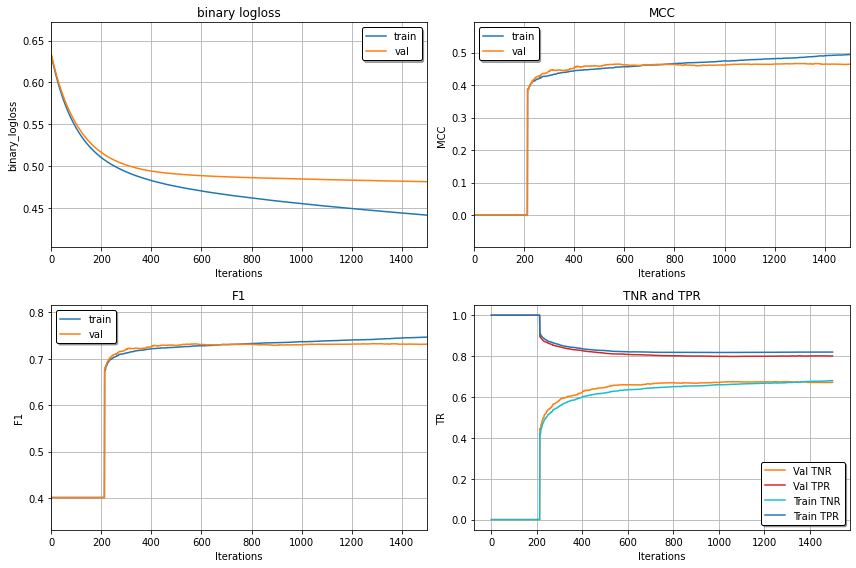

Duration: 0:21:00.879093

> Starting CV iteration 2, valid chrs = ['chr15' 'chr1' 'chr20']


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.57913	train's MCC: 0	train's F1: 0.400549	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.577579	val's MCC: 0	val's F1: 0.404746	val's TNR: 0	val's TPR: 1
[100]	train's binary_logloss: 0.545386	train's MCC: 0	train's F1: 0.400549	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.548412	val's MCC: 0	val's F1: 0.404746	val's TNR: 0	val's TPR: 1
[150]	train's binary_logloss: 0.523766	train's MCC: 0	train's F1: 0.400549	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.530226	val's MCC: 0	val's F1: 0.404746	val's TNR: 0	val's TPR: 1
[200]	train's binary_logloss: 0.509259	train's MCC: 0	train's F1: 0.400549	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.518662	val's MCC: 0	val's F1: 0.404746	val's TNR: 0	val's TPR: 1
[250]	train's binary_logloss: 0.49909	train's MCC: 0.428822	train's F1: 0.70963	train's TNR: 0.528527	train's TPR: 0.871542	val's binary_logloss: 0.511145	val's MCC: 0.395709	val's F1: 0.694895	val's TNR: 0.51833	val's TPR: 0.

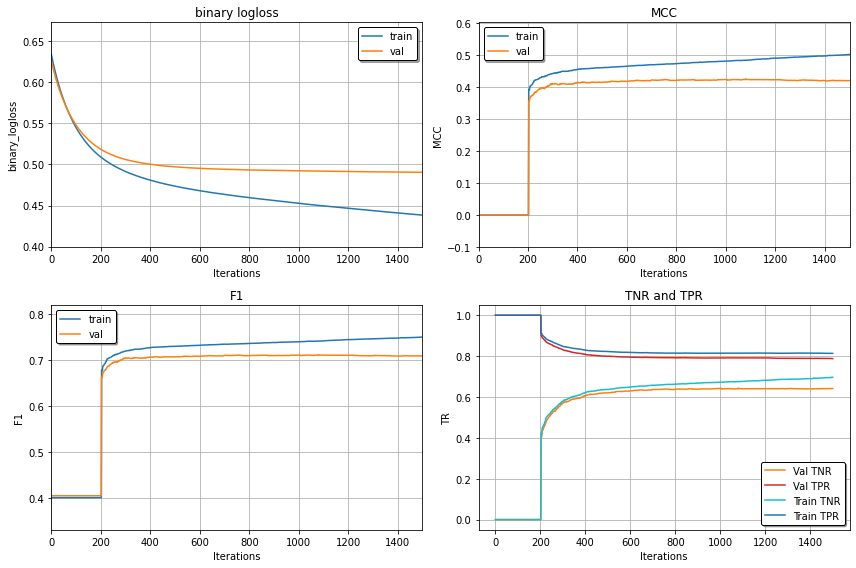

Duration: 0:20:42.050690

> Starting CV iteration 3, valid chrs = ['chr11' 'chr22' 'chrY']


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.57748	train's MCC: 0	train's F1: 0.401916	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.593231	val's MCC: 0	val's F1: 0.395649	val's TNR: 0	val's TPR: 1
[100]	train's binary_logloss: 0.544202	train's MCC: 0	train's F1: 0.401916	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.562915	val's MCC: 0	val's F1: 0.395649	val's TNR: 0	val's TPR: 1
[150]	train's binary_logloss: 0.522871	train's MCC: 0	train's F1: 0.401916	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.544376	val's MCC: 0	val's F1: 0.395649	val's TNR: 0	val's TPR: 1
[200]	train's binary_logloss: 0.508592	train's MCC: 0	train's F1: 0.401916	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.532466	val's MCC: 0	val's F1: 0.395649	val's TNR: 0	val's TPR: 1
[250]	train's binary_logloss: 0.498567	train's MCC: 0.424936	train's F1: 0.706574	train's TNR: 0.51393	train's TPR: 0.87821	val's binary_logloss: 0.52493	val's MCC: 0.355259	val's F1: 0.667449	val's TNR: 0.448305	val's TPR: 0.

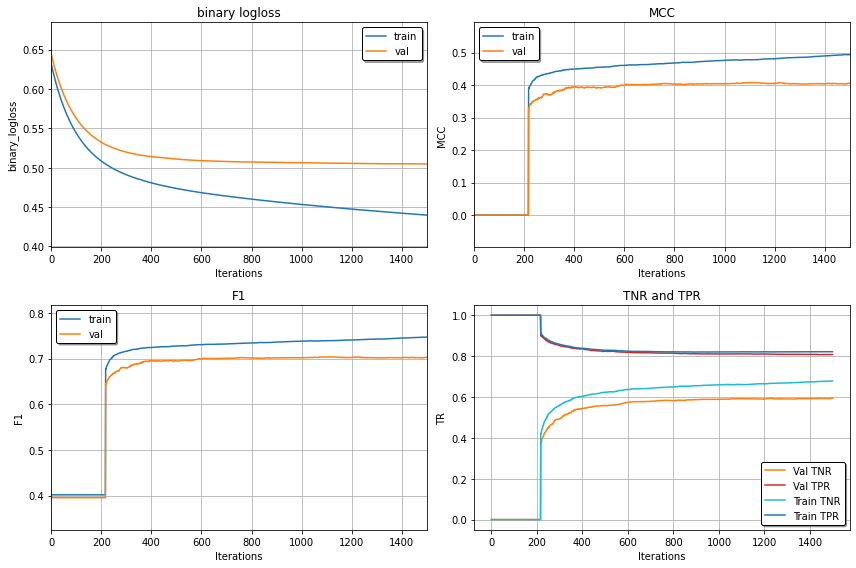

Duration: 0:21:39.550059

> Starting CV iteration 4, valid chrs = ['chr21' 'chr5' 'chr7']


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.577937	train's MCC: 0	train's F1: 0.401919	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.587853	val's MCC: 0	val's F1: 0.39765	val's TNR: 0	val's TPR: 1
[100]	train's binary_logloss: 0.545044	train's MCC: 0	train's F1: 0.401919	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.555739	val's MCC: 0	val's F1: 0.39765	val's TNR: 0	val's TPR: 1
[150]	train's binary_logloss: 0.524001	train's MCC: 0	train's F1: 0.401919	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.535067	val's MCC: 0	val's F1: 0.39765	val's TNR: 0	val's TPR: 1
[200]	train's binary_logloss: 0.509889	train's MCC: 0	train's F1: 0.401919	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.521553	val's MCC: 0	val's F1: 0.39765	val's TNR: 0	val's TPR: 1
[250]	train's binary_logloss: 0.500005	train's MCC: 0.416634	train's F1: 0.701684	train's TNR: 0.502453	train's TPR: 0.879596	val's binary_logloss: 0.512401	val's MCC: 0.415616	val's F1: 0.703432	val's TNR: 0.528412	val's TPR: 0.

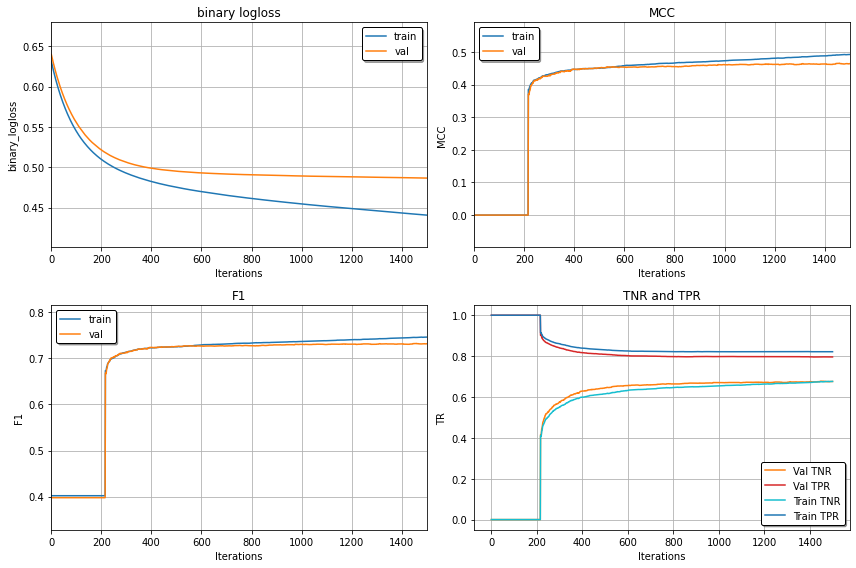

Duration: 0:21:09.355580

> Starting CV iteration 5, valid chrs = ['chr8' 'chr18' 'chr19']


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.578958	train's MCC: 0	train's F1: 0.401245	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.579663	val's MCC: 0	val's F1: 0.402017	val's TNR: 0	val's TPR: 1
[100]	train's binary_logloss: 0.545836	train's MCC: 0	train's F1: 0.401245	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.548191	val's MCC: 0	val's F1: 0.402017	val's TNR: 0	val's TPR: 1
[150]	train's binary_logloss: 0.524581	train's MCC: 0	train's F1: 0.401245	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.528608	val's MCC: 0	val's F1: 0.402017	val's TNR: 0	val's TPR: 1
[200]	train's binary_logloss: 0.510351	train's MCC: 0	train's F1: 0.401245	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.51584	val's MCC: 0	val's F1: 0.402017	val's TNR: 0	val's TPR: 1
[250]	train's binary_logloss: 0.500361	train's MCC: 0.422017	train's F1: 0.705173	train's TNR: 0.513583	train's TPR: 0.876282	val's binary_logloss: 0.507509	val's MCC: 0.386222	val's F1: 0.681734	val's TNR: 0.450368	val's TPR:

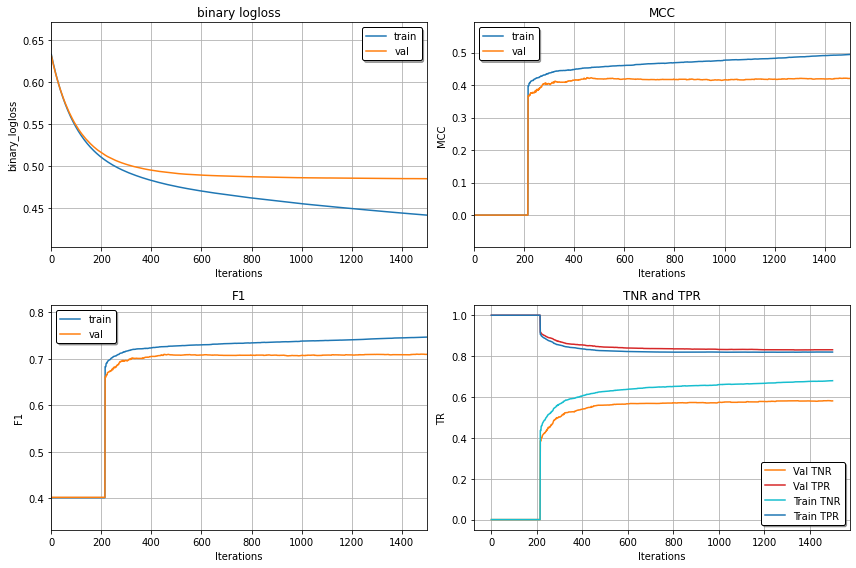

Duration: 0:21:14.984429

> Starting CV iteration 6, valid chrs = ['chrX' 'chr6' 'chr17']


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.580075	train's MCC: 0	train's F1: 0.400633	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.574683	val's MCC: 0	val's F1: 0.404842	val's TNR: 0	val's TPR: 1
[100]	train's binary_logloss: 0.546881	train's MCC: 0	train's F1: 0.400633	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.54354	val's MCC: 0	val's F1: 0.404842	val's TNR: 0	val's TPR: 1
[150]	train's binary_logloss: 0.525568	train's MCC: 0	train's F1: 0.400633	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.523963	val's MCC: 0	val's F1: 0.404842	val's TNR: 0	val's TPR: 1
[200]	train's binary_logloss: 0.511283	train's MCC: 0	train's F1: 0.400633	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.511361	val's MCC: 0	val's F1: 0.404842	val's TNR: 0	val's TPR: 1
[250]	train's binary_logloss: 0.501244	train's MCC: 0.416881	train's F1: 0.703443	train's TNR: 0.518488	train's TPR: 0.869511	val's binary_logloss: 0.502918	val's MCC: 0.40683	val's F1: 0.6984	val's TNR: 0.504587	val's TPR: 0.

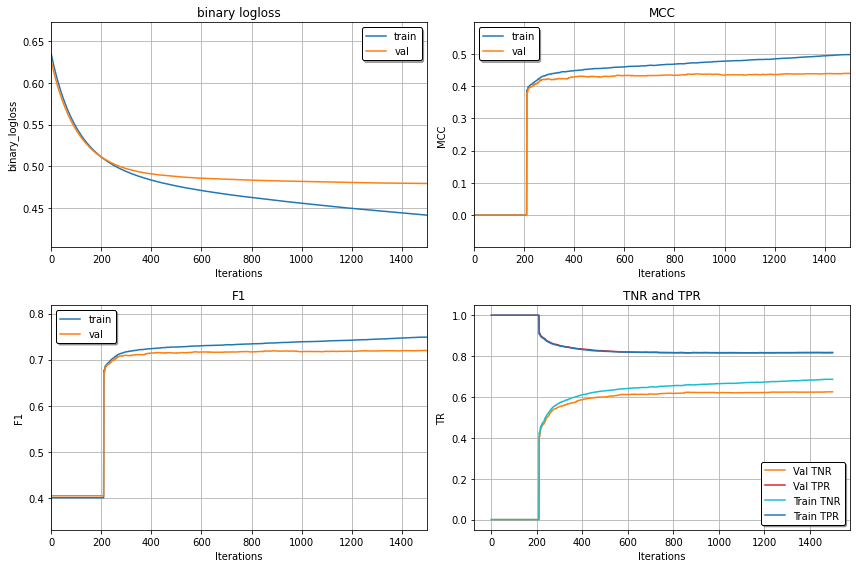

Duration: 0:20:57.439923

> Starting CV iteration 7, valid chrs = ['chr16' 'chr14' 'chr9']


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.578416	train's MCC: 0	train's F1: 0.401651	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.584148	val's MCC: 0	val's F1: 0.399453	val's TNR: 0	val's TPR: 1
[100]	train's binary_logloss: 0.545327	train's MCC: 0	train's F1: 0.401651	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.552256	val's MCC: 0	val's F1: 0.399453	val's TNR: 0	val's TPR: 1
[150]	train's binary_logloss: 0.524062	train's MCC: 0	train's F1: 0.401651	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.532148	val's MCC: 0	val's F1: 0.399453	val's TNR: 0	val's TPR: 1
[200]	train's binary_logloss: 0.509802	train's MCC: 0	train's F1: 0.401651	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.519374	val's MCC: 0	val's F1: 0.399453	val's TNR: 0	val's TPR: 1
[250]	train's binary_logloss: 0.499777	train's MCC: 0.418788	train's F1: 0.70289	train's TNR: 0.50534	train's TPR: 0.879235	val's binary_logloss: 0.510992	val's MCC: 0.393869	val's F1: 0.687758	val's TNR: 0.473364	val's TPR: 

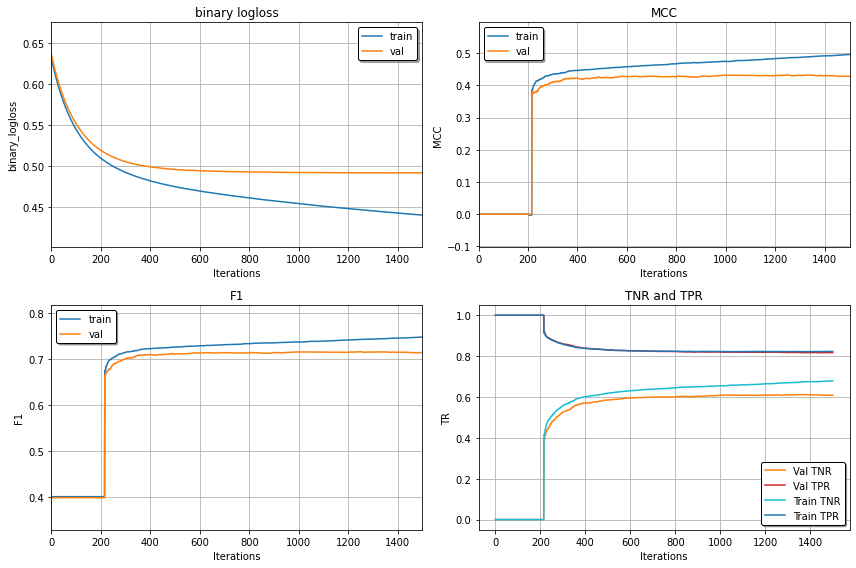

Duration: 0:21:12.692213

>> LGBM final report
Train CV accuracy: 0.7742
Train CV F1-score: 0.8295
Train MCC: 0.4956
Valid CV accuracy: 0.749
Valid CV F1-score: 0.8117
Valid CV MCC: 0.4353
Valid TNR = 63.07%
Valid TPR = 80.71%
Duration: 2:28:11.570826


In [24]:
params = {"application" : "binary",
          "metric" :"binary_logloss",
          "force_row_wise" : True,
          "learning_rate" : learning_rate,
}
lgb1_train_output, lgb1_val_output, _ = lgb_cv(X_TRAIN, y_TRAIN, metadata_train, params,
                                               cv_seed=33)

In [25]:
# # LGBM balancing the weigths by custom function
# params = {"application" : "binary",
#           "metric" :"binary_logloss",
#           "force_row_wise" : True,
#           "learning_rate" : learning_rate            
# }
# lgb2_train_output, lgb2_val_output, _ = lgb_cv(X_TRAIN, y_TRAIN, metadata_train, params, cv_seed=33,
#                                                      class_weigth="custom", name= "LGBM balanced")

Performing LGBM pos weights x0.9 CV

Parameters:
  num_iterations = 1500
  early_stopping_rounds = None
  application = binary
  metric = binary_logloss
  force_row_wise = True
  learning_rate = 0.009
  scale_pos_weight = 0.9

> Starting CV iteration 1, valid chrs = ['chr13' 'chr12' 'chr10']


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.577174	train's MCC: 0	train's F1: 0.401416	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.581148	val's MCC: 0	val's F1: 0.400946	val's TNR: 0	val's TPR: 1
[100]	train's binary_logloss: 0.544356	train's MCC: 0	train's F1: 0.401416	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.549545	val's MCC: 0	val's F1: 0.400946	val's TNR: 0	val's TPR: 1
[150]	train's binary_logloss: 0.523725	train's MCC: 0	train's F1: 0.401416	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.529664	val's MCC: 0	val's F1: 0.400946	val's TNR: 0	val's TPR: 1
[200]	train's binary_logloss: 0.510088	train's MCC: 0.422622	train's F1: 0.707872	train's TNR: 0.536503	train's TPR: 0.862279	val's binary_logloss: 0.516791	val's MCC: 0.42994	val's F1: 0.713052	val's TNR: 0.561359	val's TPR: 0.851256
[250]	train's binary_logloss: 0.500568	train's MCC: 0.438341	train's F1: 0.71886	train's TNR: 0.600294	train's TPR: 0.831366	val's binary_logloss: 0.508494	val's MCC: 0.44703	val's F1:

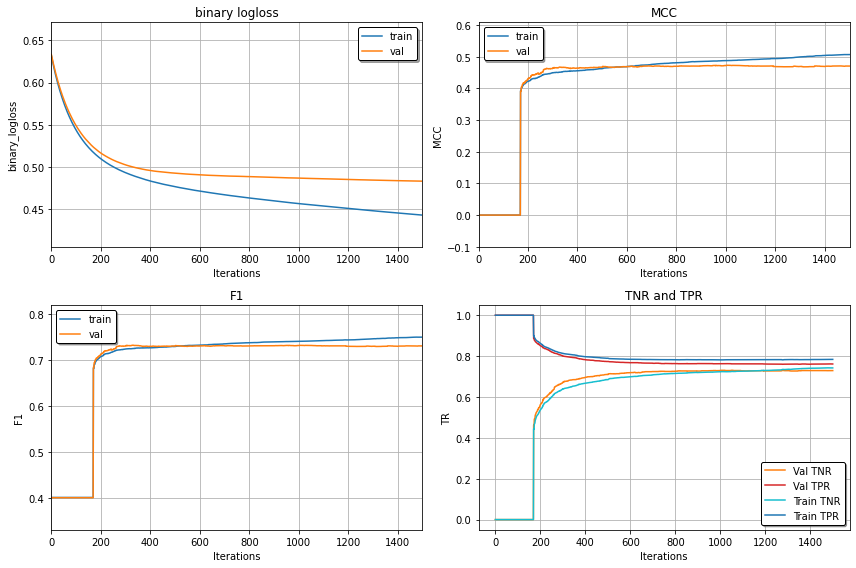

Duration: 0:21:13.476743

> Starting CV iteration 2, valid chrs = ['chr15' 'chr1' 'chr20']


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.577565	train's MCC: 0	train's F1: 0.400549	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.576668	val's MCC: 0	val's F1: 0.404746	val's TNR: 0	val's TPR: 1
[100]	train's binary_logloss: 0.543847	train's MCC: 0	train's F1: 0.400549	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.547883	val's MCC: 0	val's F1: 0.404746	val's TNR: 0	val's TPR: 1
[150]	train's binary_logloss: 0.522645	train's MCC: 0	train's F1: 0.400549	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.530339	val's MCC: 0	val's F1: 0.404746	val's TNR: 0	val's TPR: 1
[200]	train's binary_logloss: 0.508601	train's MCC: 0.435882	train's F1: 0.715702	train's TNR: 0.561386	train's TPR: 0.855522	val's binary_logloss: 0.519381	val's MCC: 0.396572	val's F1: 0.697208	val's TNR: 0.54682	val's TPR: 0.837214
[250]	train's binary_logloss: 0.498813	train's MCC: 0.453251	train's F1: 0.726593	train's TNR: 0.627203	train's TPR: 0.823926	val's binary_logloss: 0.512287	val's MCC: 0.413105	val's F

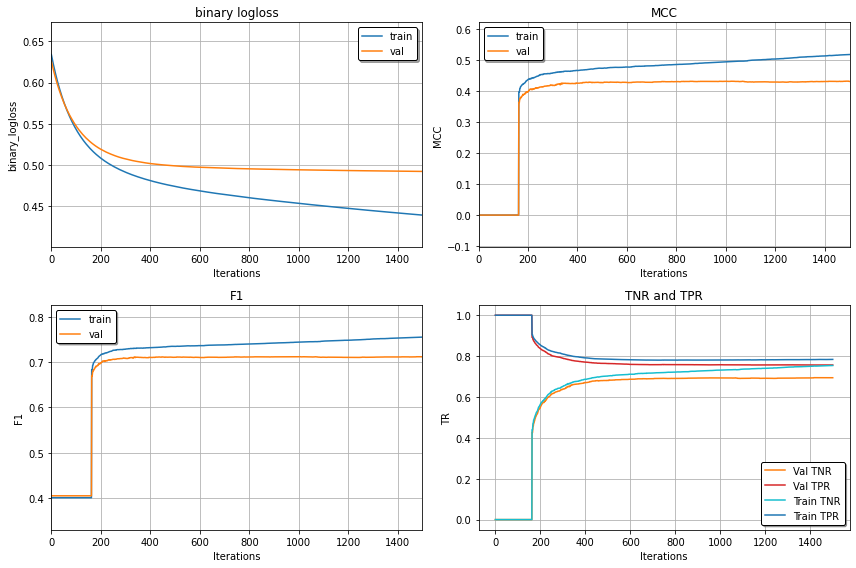

Duration: 0:20:53.669675

> Starting CV iteration 3, valid chrs = ['chr11' 'chr22' 'chrY']


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.575895	train's MCC: 0	train's F1: 0.401916	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.591237	val's MCC: 0	val's F1: 0.395649	val's TNR: 0	val's TPR: 1
[100]	train's binary_logloss: 0.542744	train's MCC: 0	train's F1: 0.401916	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.560485	val's MCC: 0	val's F1: 0.395649	val's TNR: 0	val's TPR: 1
[150]	train's binary_logloss: 0.521817	train's MCC: 0	train's F1: 0.401916	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.541805	val's MCC: 0	val's F1: 0.395649	val's TNR: 0	val's TPR: 1
[200]	train's binary_logloss: 0.507941	train's MCC: 0.429131	train's F1: 0.711345	train's TNR: 0.542464	train's TPR: 0.863253	val's binary_logloss: 0.530277	val's MCC: 0.369049	val's F1: 0.678102	val's TNR: 0.483475	val's TPR: 0.857175
[250]	train's binary_logloss: 0.498303	train's MCC: 0.446146	train's F1: 0.722772	train's TNR: 0.605105	train's TPR: 0.834324	val's binary_logloss: 0.523028	val's MCC: 0.392331	val's 

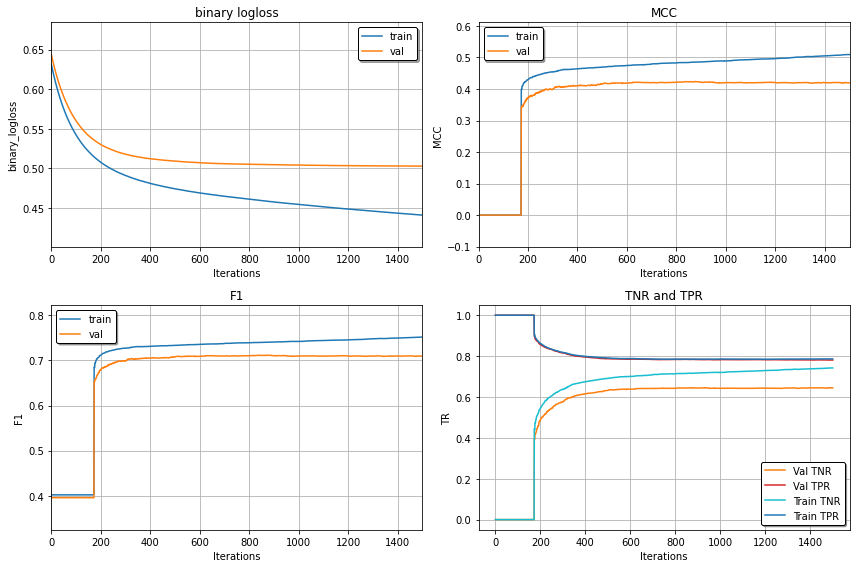

Duration: 0:21:41.523646

> Starting CV iteration 4, valid chrs = ['chr21' 'chr5' 'chr7']


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.576395	train's MCC: 0	train's F1: 0.401919	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.586234	val's MCC: 0	val's F1: 0.39765	val's TNR: 0	val's TPR: 1
[100]	train's binary_logloss: 0.543541	train's MCC: 0	train's F1: 0.401919	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.554251	val's MCC: 0	val's F1: 0.39765	val's TNR: 0	val's TPR: 1
[150]	train's binary_logloss: 0.522886	train's MCC: 0	train's F1: 0.401919	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.534159	val's MCC: 0	val's F1: 0.39765	val's TNR: 0	val's TPR: 1
[200]	train's binary_logloss: 0.509246	train's MCC: 0.423652	train's F1: 0.708196	train's TNR: 0.534292	train's TPR: 0.864562	val's binary_logloss: 0.52119	val's MCC: 0.423857	val's F1: 0.709828	val's TNR: 0.560047	val's TPR: 0.846653
[250]	train's binary_logloss: 0.499714	train's MCC: 0.443489	train's F1: 0.721411	train's TNR: 0.602123	train's TPR: 0.834312	val's binary_logloss: 0.512557	val's MCC: 0.447677	val's F1: 

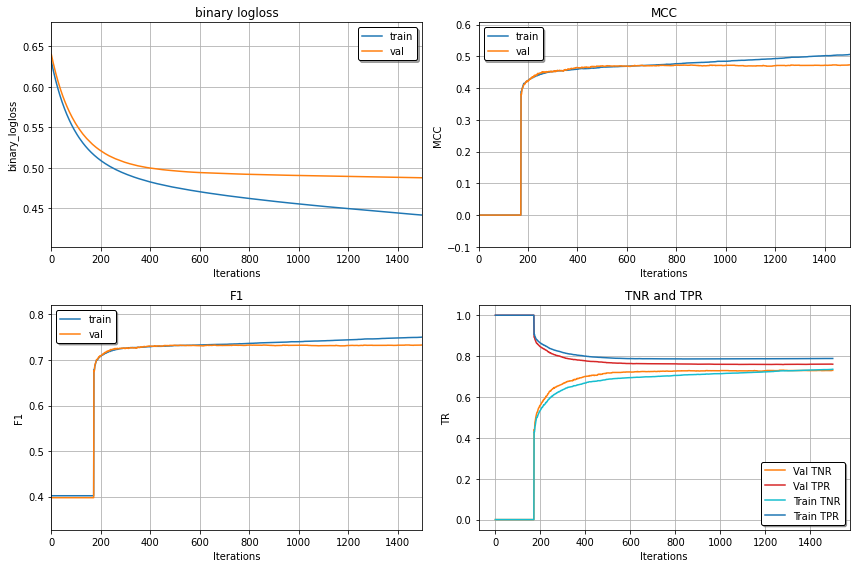

Duration: 0:21:23.259654

> Starting CV iteration 5, valid chrs = ['chr8' 'chr18' 'chr19']


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.577417	train's MCC: 0	train's F1: 0.401245	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.578129	val's MCC: 0	val's F1: 0.402017	val's TNR: 0	val's TPR: 1
[100]	train's binary_logloss: 0.544301	train's MCC: 0	train's F1: 0.401245	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.546577	val's MCC: 0	val's F1: 0.402017	val's TNR: 0	val's TPR: 1
[150]	train's binary_logloss: 0.5235	train's MCC: 0	train's F1: 0.401245	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.527185	val's MCC: 0	val's F1: 0.402017	val's TNR: 0	val's TPR: 1
[200]	train's binary_logloss: 0.509734	train's MCC: 0.428987	train's F1: 0.711531	train's TNR: 0.546464	train's TPR: 0.860397	val's binary_logloss: 0.514763	val's MCC: 0.40204	val's F1: 0.693625	val's TNR: 0.486826	val's TPR: 0.879331
[250]	train's binary_logloss: 0.500101	train's MCC: 0.444547	train's F1: 0.721967	train's TNR: 0.604871	train's TPR: 0.832984	val's binary_logloss: 0.506681	val's MCC: 0.411386	val's F1:

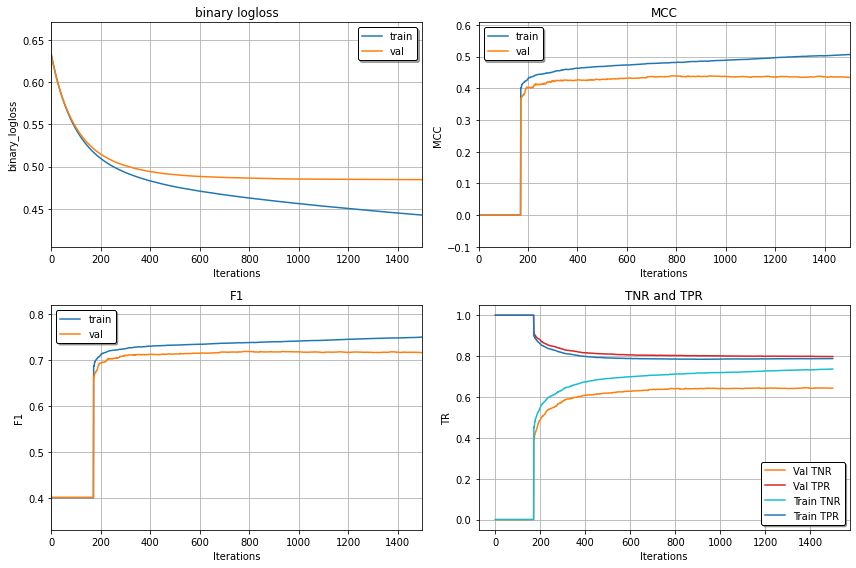

Duration: 0:21:19.414783

> Starting CV iteration 6, valid chrs = ['chrX' 'chr6' 'chr17']


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.578506	train's MCC: 0	train's F1: 0.400633	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.573539	val's MCC: 0	val's F1: 0.404842	val's TNR: 0	val's TPR: 1
[100]	train's binary_logloss: 0.545329	train's MCC: 0	train's F1: 0.400633	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.542626	val's MCC: 0	val's F1: 0.404842	val's TNR: 0	val's TPR: 1
[150]	train's binary_logloss: 0.524455	train's MCC: 0	train's F1: 0.400633	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.523485	val's MCC: 0	val's F1: 0.404842	val's TNR: 0	val's TPR: 1
[200]	train's binary_logloss: 0.510606	train's MCC: 0.427122	train's F1: 0.711174	train's TNR: 0.553423	train's TPR: 0.854326	val's binary_logloss: 0.511309	val's MCC: 0.419003	val's F1: 0.707133	val's TNR: 0.541284	val's TPR: 0.857559
[250]	train's binary_logloss: 0.500943	train's MCC: 0.4455	train's F1: 0.722599	train's TNR: 0.613284	train's TPR: 0.827621	val's binary_logloss: 0.503301	val's MCC: 0.430784	val's F1

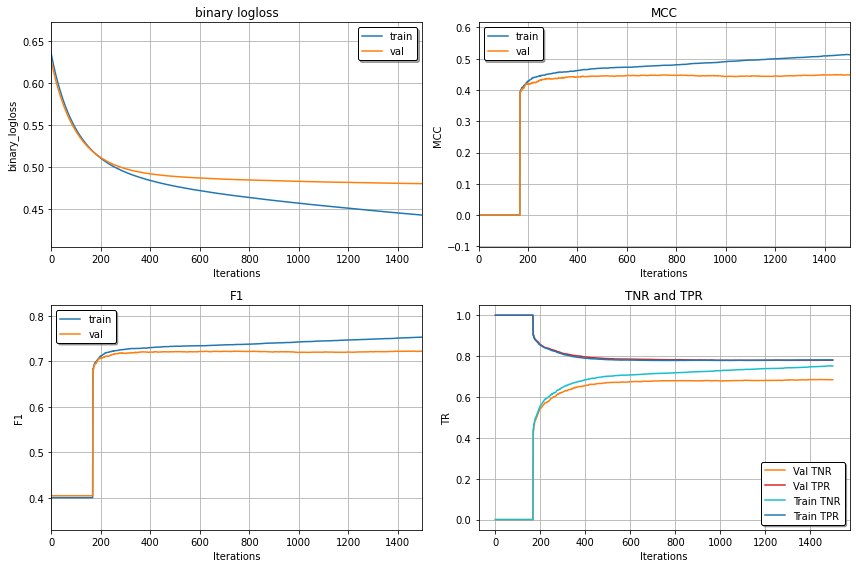

Duration: 0:21:03.615415

> Starting CV iteration 7, valid chrs = ['chr16' 'chr14' 'chr9']


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.576873	train's MCC: 0	train's F1: 0.401651	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.582419	val's MCC: 0	val's F1: 0.399453	val's TNR: 0	val's TPR: 1
[100]	train's binary_logloss: 0.543797	train's MCC: 0	train's F1: 0.401651	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.550498	val's MCC: 0	val's F1: 0.399453	val's TNR: 0	val's TPR: 1
[150]	train's binary_logloss: 0.522981	train's MCC: 0	train's F1: 0.401651	train's TNR: 0	train's TPR: 1	val's binary_logloss: 0.530847	val's MCC: 0	val's F1: 0.399453	val's TNR: 0	val's TPR: 1
[200]	train's binary_logloss: 0.509166	train's MCC: 0.424287	train's F1: 0.708465	train's TNR: 0.534641	train's TPR: 0.864724	val's binary_logloss: 0.518399	val's MCC: 0.398803	val's F1: 0.693865	val's TNR: 0.503764	val's TPR: 0.865909
[250]	train's binary_logloss: 0.499517	train's MCC: 0.440683	train's F1: 0.719918	train's TNR: 0.597637	train's TPR: 0.835123	val's binary_logloss: 0.510321	val's MCC: 0.418011	val's 

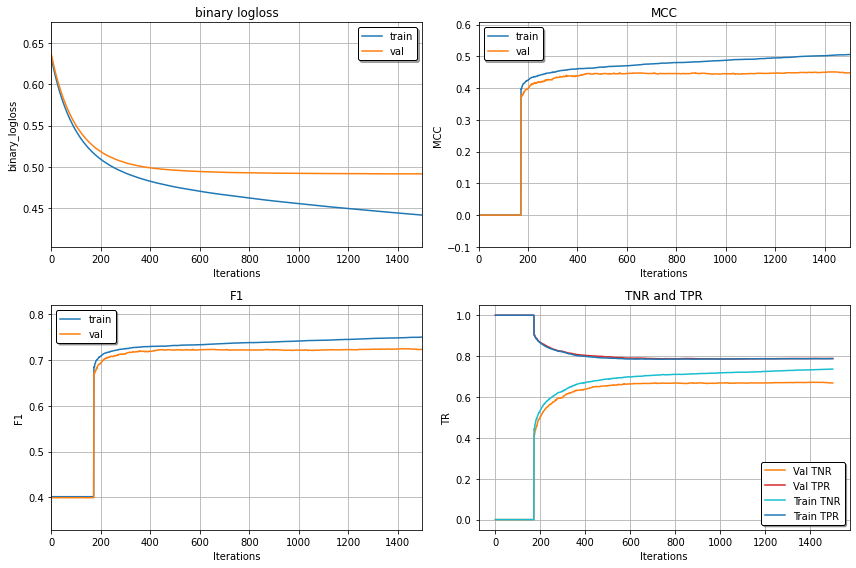

Duration: 0:21:15.305475

>> LGBM pos weights x0.9 final report
Train CV accuracy: 0.7714
Train CV F1-score: 0.8216
Train MCC: 0.5093
Valid CV accuracy: 0.7453
Valid CV F1-score: 0.8029
Valid CV MCC: 0.447
Valid TNR = 68.74%
Valid TPR = 77.37%
Duration: 2:29:04.200523


In [26]:
# LGBM balancing the weigths scale_pos_weight x2
params = {"application" : "binary",
          "metric" : "binary_logloss",
          "force_row_wise" : True,
          "learning_rate" : learning_rate,
          "scale_pos_weight": 0.9          
}
lgb2_train_output, lgb2_val_output, _ = lgb_cv(X_TRAIN, y_TRAIN, metadata_train, params, cv_seed=33,
                                               name = "LGBM pos weights x0.9")

## SVM

SVM SVC model

In [27]:
# # Train and predict SVM SVC
# def svc_train_pred(xtrain, ytrain, xtest, ytest, model, name="SVM SVC"):
#   start_time = datetime.now()
#   # Train and predict
#   model = model.fit(xtrain, ytrain)
#   ytrain_prob = model.predict_proba(xtrain)[:,1]
#   ytest_prob = model.predict_proba(xtest)[:,1]
#   ytrain_pred = model.predict(xtrain)
#   ytest_pred = model.predict(xtest)
#   # Evaluate
#   print(f"{name} train accuracy: {get_accuracy(ytrain_pred, ytrain):.4}")
#   print(f"{name} test accuracy: {get_accuracy(ytest_pred, ytest):.4}")
#   # Report time 
#   print(f"Duration: {datetime.now() - start_time}")
#   return model, ytrain_prob, ytrain_pred, ytest_prob, ytest_pred

# svc_rbf = svm.SVC(kernel='rbf', C=100, gamma=0.1, probability=True)
# #svc_model, svc_train_yprob, svc_train_ypred, svc_val_yprob, svc_val_ypred = svc_train_pred(X_train, y_train, X_val, y_val, model=svc_rbf)

SVM SVR with Logistic Regression on top of the SVM scores

In [28]:
# # Train and predict 
# def svrlr_train_pred(xtrain, ytrain, xtest, ytest, model, name="SVM SVR"):
#   start_time = datetime.now()
#   # Train and predict svm score
#   svm_model = model.fit(xtrain, ytrain)
#   svm_train_yscore = svm_model.predict(xtrain).reshape(-1,1)
#   svm_test_yscore = svm_model.predict(xtest).reshape(-1,1)
#   # Train a logistic regression on top of svm output
#   lreg_model = LogisticRegression(solver='lbfgs', 
#                                   random_state=0, 
#                                   max_iter = 2000).fit(svm_train_yscore, 
#                                                        ytrain)
#   train_yprob = lreg_model.predict_proba(svm_train_yscore)[:,1]
#   train_ypred = lreg_model.predict(svm_train_yscore)
#   test_yprob = lreg_model.predict_proba(svm_test_yscore)[:,1]
#   test_ypred = lreg_model.predict(svm_test_yscore)
#   # Evaluate
#   print(f"{name} train accuracy: {get_accuracy(train_ypred, ytrain):.4}")
#   print(f"{name} test accuracy: {get_accuracy(test_ypred, ytest):.4}")
#   # Report time 
#   print(f"Duration: {datetime.now() - start_time}")
#   return svm_model, lreg_model, train_yprob, train_ypred, test_yprob, test_ypred

# svr_rbf = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
# #_, _, svm_train_yprob, svm_train_ypred, svm_val_yprob, svm_val_ypred = svrlr_train_pred(X_train, y_train, X_val, y_val, model=svr_rbf)

SVM CV both SVC and SVR + LG

In [29]:
# # SVM CV
# def svm_cv(xtrain, ytrain, model=svc_rbf, svm_algo="SVC", kfold=10, name="SVM"):
#   start_time = datetime.now()
#   print(f"Performing {name} {svm_algo} CV")
#   # Initialize 1d df to store predictions and true values
#   train_yprob_vec, train_ypred_vec, train_ytrue_vec = np.array([]), np.array([]), np.array([])
#   val_yprob_vec, val_ypred_vec, val_ytrue_vec = np.array([]), np.array([]), np.array([])
#   # Stratified CV
#   skf = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=26)
#   for i, (itrain, ival) in enumerate(skf.split(xtrain, ytrain)):
#     print(f"\n> Starting CV iteration {i+1}")
#     # Split data according to folds
#     X_train, X_val = xtrain.iloc[itrain], xtrain.iloc[ival]
#     y_train, y_val = ytrain[itrain], ytrain[ival]
#     # Normalization
#     scaler = StandardScaler()
#     X_train = scaler.fit_transform(X_train)
#     X_val = scaler.transform(X_val)
#     # Train and predict
#     if svm_algo=="SVC":
#       _, train_yprob, train_ypred, val_yprob, val_ypred = svc_train_pred(X_train, y_train, X_val, y_val, model=model)
#     elif svm_algo=="SVR":
#       _, _, train_yprob, train_ypred, val_yprob, val_ypred = svrlr_train_pred(X_train, y_train, X_val, y_val, model=model)
#     else:
#       print("svm_algo argument must specify \"SVC\" or \"SVR\"")
#     # Store prediction on training data
#     train_yprob_vec = np.concatenate((train_yprob_vec, train_yprob))
#     train_ypred_vec = np.concatenate((train_ypred_vec, train_ypred))
#     train_ytrue_vec = np.concatenate((train_ytrue_vec, y_train))
#     # Store prediction on validation data
#     val_yprob_vec = np.concatenate((val_yprob_vec, val_yprob))
#     val_ypred_vec = np.concatenate((val_ypred_vec, val_ypred))
#     val_ytrue_vec = np.concatenate((val_ytrue_vec, y_val))
#   # Stack training and validation predictions into two panda df
#   train_output = pd.DataFrame({"yprob": train_yprob_vec, "ypred": train_ypred_vec,"ytrue": train_ytrue_vec})
#   val_output = pd.DataFrame({"yprob": val_yprob_vec, "ypred": val_ypred_vec,"ytrue": val_ytrue_vec})
#   # Evaluate
#   train_acc = get_accuracy(train_output["ypred"].values, train_output["ytrue"].values)
#   val_acc = get_accuracy(val_output["ypred"].values, val_output["ytrue"].values)
#   train_rmse = get_rmse(train_output["yprob"].values, train_output["ytrue"].values)
#   val_rmse = get_rmse(val_output["yprob"].values, val_output["ytrue"].values)
#   print(f"\n>> {name} final report")
#   print(f"Train CV accuracy: {train_acc:.4}")
#   print(f"Valid CV accuracy: {val_acc:.4}")
#   # Report time 
#   print(f"Duration: {datetime.now() - start_time}")
#   return train_output, val_output

# # # SVC CV
# # svc_train_output, svc_val_output = svm_cv(X_TRAIN, y_TRAIN, 
# #                                           svm_algo="SVC", kfold=2, model=svc_rbf)

In [30]:
# # SVR CV
# svr_train_output, svr_val_output = svm_cv(X_TRAIN, y_TRAIN, 
#                                           svm_algo="SVR", kfold=2, model=svr_rbf)

## Features importance

In [31]:
# # Feature importance
# plt.figure(figsize=(12, 8))
# gs = gridspec.GridSpec(1, 2)

# ax = plt.subplot(gs[0, 0])
# sns.barplot(x='average', y='feature', data=rf_importance.sort_values('average', ascending=False).iloc[0:20], ax=ax)
# plt.title("Random forest feature importance", fontsize=15)

# ax = plt.subplot(gs[0, 1])
# sns.barplot(x='average', y='feature', data=lgb_importance.sort_values('average', ascending=False).iloc[0:20], ax=ax)
# plt.title("LightGBM feature importance gain", fontsize=15)

# # ax = plt.subplot(gs[0, 2])
# # sns.barplot(x='lgb_importance_split', y='feature', data=imp_df.sort_values('lgb_importance_split', ascending=False).iloc[0:20], ax=ax)
# # ax.set_title('LightGBM feature importance split', fontsize=15)
# plt.tight_layout()
# plt.savefig(f"{DIRECTORY}feature_importance_{FILENAME}.png", dpi = 300)
# plt.show()

# # Export files
# rf_importance.to_csv(f"{DIRECTORY}rf_importance_{FILENAME}.csv", index=False)
# lgb_importance.to_csv(f"{DIRECTORY}lgb_importance_{FILENAME}.csv", index=False)

In [32]:
# # LGBM Feature importance
# plt.rcParams['figure.figsize'] = (18.0, 4)
# fig, ax = plt.subplots(figsize=(12,8))
# lgb.plot_importance(lgb_model, max_num_features=20, height=0.8, ax=ax)
# ax.grid(False)
# plt.title("LightGBM feature importance ", fontsize=15)

## Performance evaluation

In [33]:
# Initialize the models to evaluate
train_output_lst = rf1_train_output, lgb1_train_output, lgb2_train_output     # rf_bal_train_output, rf_custom_train_output # lgb_bal_train_output, lgb_custom_train_output,
val_output_lst = rf1_val_output, lgb1_val_output, lgb2_val_output  
names = "RF bal", "LGBM", "LGBM pos X0.9"               # "RF bal", "RF cst bal", # "LGBM bal", "LGBM cst bal",                                            # "Tuned RF"

#### Classification report

In [34]:
# Classification report
for i in range(len(names)):
  print(f"{names[i]}:\n", classification_report(val_output_lst[i]["ytrue"], val_output_lst[i]["ypred"])) 

RF bal:
               precision    recall  f1-score   support

         0.0       0.60      0.63      0.61     24614
         1.0       0.81      0.79      0.80     50069

    accuracy                           0.74     74683
   macro avg       0.70      0.71      0.71     74683
weighted avg       0.74      0.74      0.74     74683

LGBM:
               precision    recall  f1-score   support

         0.0       0.62      0.63      0.62     24614
         1.0       0.82      0.81      0.81     50069

    accuracy                           0.75     74683
   macro avg       0.72      0.72      0.72     74683
weighted avg       0.75      0.75      0.75     74683

LGBM pos X0.9:
               precision    recall  f1-score   support

         0.0       0.60      0.69      0.64     24614
         1.0       0.83      0.77      0.80     50069

    accuracy                           0.75     74683
   macro avg       0.72      0.73      0.72     74683
weighted avg       0.76      0.75      0.7

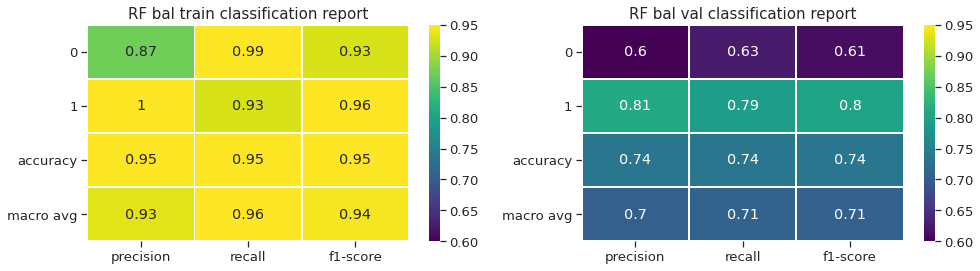

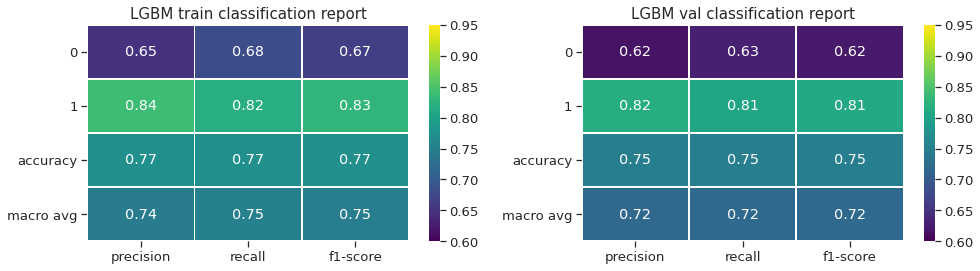

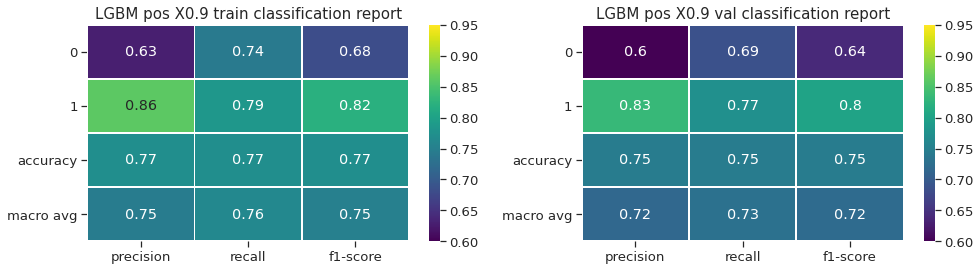

In [35]:
# Plot classification report
def plot_clf_report(train_output, val_output, name="", save=False):
  plt.figure(figsize=(14, 4))
  gs = gridspec.GridSpec(1, 2)
  sns.set(font_scale=1.2, style="ticks")
  # Train
  ax = plt.subplot(gs[0, 0])
  clf_report = classification_report(train_output["ytrue"], train_output["ypred"],
                                    labels=[0,1], output_dict=True)
  sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].drop(["weighted avg"], axis=1).T, 
              annot=True, linewidths=1, cmap="viridis", ax=ax, vmin=0.6, vmax=0.95)
  ax.set_title(f"{name} train classification report", fontsize=15)
  # Validation
  ax = plt.subplot(gs[0, 1])
  clf_report = classification_report(val_output["ytrue"], val_output["ypred"],
                                    labels=[0,1], output_dict=True)
  sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].drop(["weighted avg"], axis=1).T, 
              annot=True, linewidths=1, cmap="viridis", ax=ax, vmin=0.6, vmax=0.95)
  ax.set_title(f"{name} val classification report", fontsize=15)
  # Layout and save
  plt.tight_layout()
  if save:
    plt.savefig(f"{DIRECTORY}classification_report_{FILENAME}_{name}.png", dpi = 300)
  plt.show()

for i in range(len(names)):
  plot_clf_report(train_output_lst[i], val_output_lst[i], names[i], save=True)

#### Plot some metrics

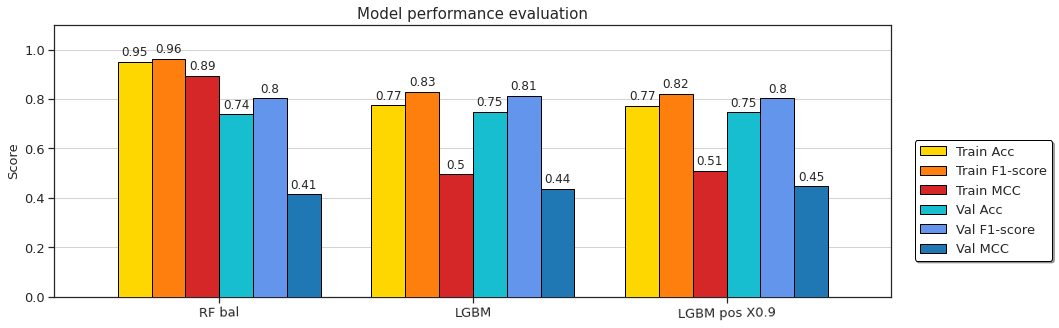

In [36]:
# Plot accuracy, F1, MCC

def evaluate(ml_output):
  acc = get_accuracy(ml_output["ypred"], ml_output["ytrue"])
  f1 = f1_score(ml_output["ytrue"], ml_output["ypred"])
  mcc = matthews_corrcoef(ml_output["ytrue"], ml_output["ypred"])
  return acc, f1, mcc

def evaluate_lst(ml_output_lst):
  lst_acc, lst_f1, lst_mcc = [], [], []
  for ml_output in ml_output_lst: 
    acc, f1, mcc = evaluate(ml_output)
    lst_acc.append(acc)
    lst_f1.append(f1)
    lst_mcc.append(mcc)
  return lst_acc, lst_f1, lst_mcc

def plot_metrics(train_output_lst, val_output_lst, names, 
                 bbox_to_anchor=(1.03, 0.6), annotation_size=13, 
                 save=False):
  # Group by metrics
  train_acc, train_f1, train_mcc = evaluate_lst(train_output_lst)
  val_acc, val_f1, val_mcc = evaluate_lst(val_output_lst)
  # Plot
  metric_df = pd.DataFrame({"Train Acc": train_acc, "Train F1-score": train_f1, "Train MCC": train_mcc,
                            "Val Acc": val_acc, "Val F1-score": val_f1, "Val MCC": val_mcc, }, 
                            index = names)
  ax = metric_df.plot(y=["Train Acc", "Train F1-score", "Train MCC", "Val Acc", "Val F1-score", "Val MCC"], 
                      ylim=(0,1.1), figsize=(15,5), fontsize=13, kind="bar", zorder=3, ec ="black",
                      rot=1, width=0.8, color = ["gold", "tab:orange", "tab:red",
                                                "tab:cyan", "cornflowerblue", "tab:blue"])
  # Add details
  plt.title("Model performance evaluation", fontsize = 15)
  plt.ylabel("Score", fontsize = 13)
  plt.grid(axis="y", zorder=0, color="lightgray")  
  legend = plt.legend(frameon = 1, shadow = True, bbox_to_anchor=bbox_to_anchor, fontsize=13)
  frame = legend.get_frame()
  frame.set_facecolor('white')
  frame.set_edgecolor('black')
  # Annotate scores on top of the bars
  for p in ax.patches:
    height = p.get_height()
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    xpos='center'
    offset = {'center': 0, 'right': 1, 'left': -1}
    ax.annotate(f"{height:.2}",
                xy=(p.get_x() + p.get_width() / 2, height),
                xytext=(offset[xpos]*3, 3),  
                textcoords="offset points",  
                ha=ha[xpos], va='bottom', size=annotation_size)
  if save:
    plt.savefig(f"{DIRECTORY}models_performance_{FILENAME}.png", 
                dpi = 300, bbox_extra_artists=(legend,), bbox_inches='tight')
  plt.show()

plot_metrics(train_output_lst, val_output_lst, names, 
             bbox_to_anchor=(1.2, 0.6), annotation_size=12, save=True)                        # annotation_size= 13 for 2, 12 for 3, 11 for 4

#### ROC

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


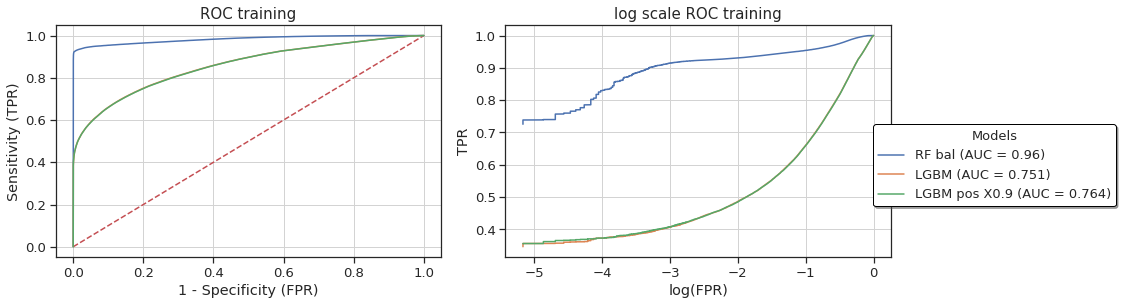

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


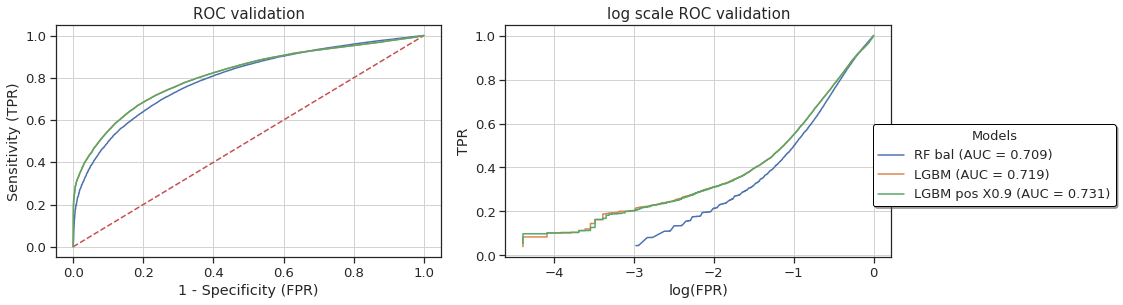

In [37]:
# Compute AUC, FPR and TPR
def get_auc_fpr_tpr(ml_output):
  auc = roc_auc_score(ml_output["ytrue"], ml_output["ypred"])
  fpr, tpr, _ = roc_curve(ml_output["ytrue"], ml_output["yprob"])
  return auc, fpr, tpr

# Plot ROC
def plot_ROC(output_lst, names, plot_name="", save=False):
  fig, axes = plt.subplots(1, 2, figsize = (16, 4.5))
  # ROC
  for i, output in enumerate(output_lst):
    auc, fpr, tpr = get_auc_fpr_tpr(output)
    axes[0].plot(fpr, tpr, label=f"{names[i]} (AUC = {auc:.3})", zorder=3)
  axes[0].plot([0, 1], [0, 1],'r--')
  axes[0].set_title(f"ROC {plot_name}", fontsize=15)
  axes[0].set_xlabel('1 - Specificity (FPR)')
  axes[0].set_ylabel('Sensitivity (TPR)')
  axes[0].grid(zorder=0, color="lightgray")
  # Log ROC
  for i, output in enumerate(output_lst):
    auc, fpr, tpr = get_auc_fpr_tpr(output)
    axes[1].plot(np.log10(fpr), tpr, label=f"{names[i]} (AUC = {auc:.3})", zorder=3)
  axes[1].set_title(f"log scale ROC {plot_name}", fontsize=15)
  axes[1].set_xlabel('log(FPR)')
  axes[1].set_ylabel('TPR')
  axes[1].grid(zorder=0, color="lightgray")
  # Details
  legend = plt.legend(title="Models", fontsize=13, title_fontsize=13,
                      frameon = 1, shadow = True, bbox_to_anchor=(1.6, 0.6))
  frame = legend.get_frame()
  frame.set_facecolor('white')
  frame.set_edgecolor('black')
  fig.tight_layout()
  fig.subplots_adjust(top=0.89)
  if save:
    plt.savefig(f"{DIRECTORY}ROC_logROC_{plot_name}_{FILENAME}.png", dpi = 300)
  plt.show()

plot_ROC(train_output_lst, names, plot_name="training", save=True)
plot_ROC(val_output_lst, names, plot_name="validation", save=True)

#### Precision recall curve

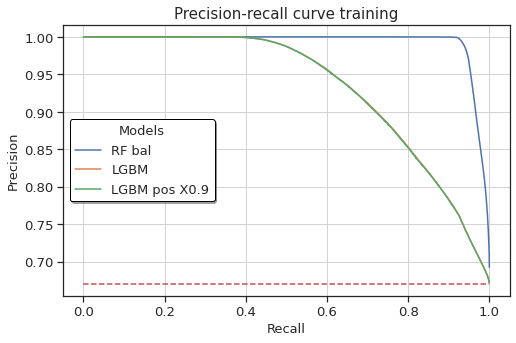

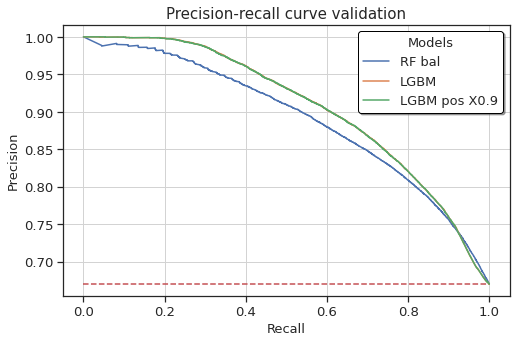

In [38]:
# Precision-recall curve
def plot_precision_recall_curve(output_lst, names, plot_name="", save=False):
  # Plot the curves
  plt.figure(figsize=(8, 5))
  random_clf = len(output_lst[0]["ytrue"][output_lst[0]["ytrue"]==1]) / len(output_lst[0]["ytrue"])
  plt.plot([0, 1], [random_clf, random_clf], 'r--', zorder=3)
  for i, val_output in enumerate(output_lst):
    precision, recall, thresholds = precision_recall_curve(val_output["ytrue"], val_output["yprob"])
    plt.plot(recall, precision, label=names[i], zorder=3)
  # Add details
  plt.grid(zorder=0, color="lightgray")
  plt.xlabel("Recall", fontsize=13)
  plt.ylabel("Precision", fontsize=13)
  plt.title(f"Precision-recall curve {plot_name}", fontsize=15)
  legend = plt.legend(title="Models", fontsize=13, title_fontsize=13,
            frameon = 1, shadow = True)
  frame = legend.get_frame()
  frame.set_facecolor("white")
  frame.set_edgecolor("black")
  if save:
    plt.savefig(f"{DIRECTORY}precision-recall_curve_{plot_name}_{FILENAME}.png", dpi = 300)
  plt.show()

plot_precision_recall_curve(train_output_lst, names, plot_name="training", save=True)
plot_precision_recall_curve(val_output_lst, names, plot_name="validation", save=True)

#### Confusion matrix

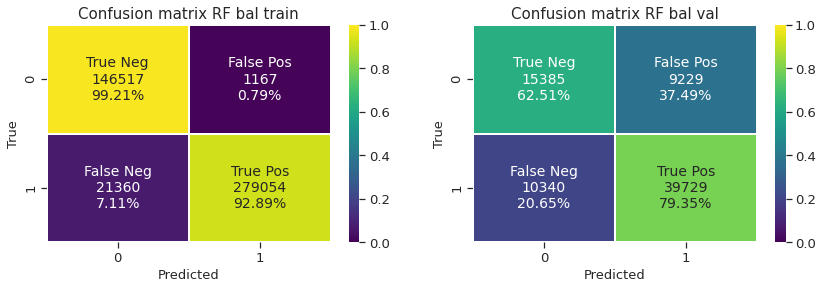

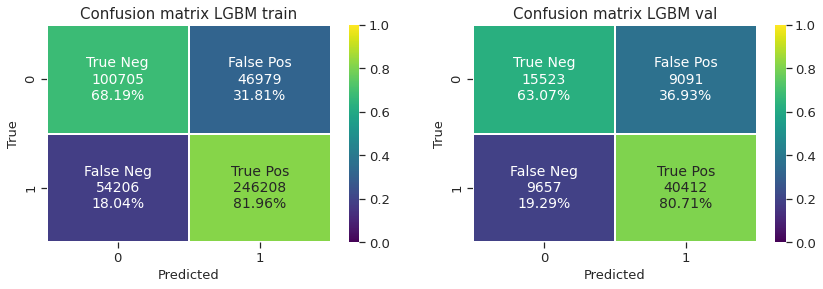

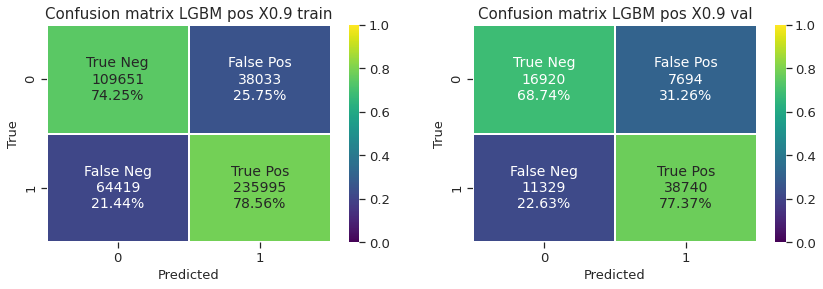

In [39]:
# Plot confusion matrix
def plot_confusion_matrix(train_output, val_output, name="",
                          vmax=0.6, save=False, filename="", cmap='viridis'):
  # Initialize
  val_train_output = train_output, val_output
  plot_names = "train", "val"
  plt.figure(figsize=(14, 4))
  gs = gridspec.GridSpec(1, 2)
  sns.set(font_scale=1.2, style="ticks")
  # Plot train and validation 
  for i, output in enumerate(val_train_output):
    ax = plt.subplot(gs[0, i])
    # Get confusion matrix and labels
    cf_matrix = confusion_matrix(output["ytrue"], output["ypred"])
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = [f"{value}" for value in cf_matrix.flatten()]
    row_sums = cf_matrix.sum(axis=1)
    norm_matrix = cf_matrix / row_sums[:, np.newaxis]
    group_percentages = [f"{value*100:.2f}%" for value in norm_matrix.flatten()]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    # Plot heatmap
    sns.heatmap(norm_matrix, annot=labels, annot_kws={"size": 14}, 
                fmt="", vmin=0, vmax=1, cmap=cmap, linewidths=1, ax=ax)
    plt.ylabel("True", fontsize = 13)
    plt.xlabel("Predicted", fontsize = 13)
    plt.title(f"Confusion matrix {name} {plot_names[i]}", fontsize = 15)
  if save:
    plt.savefig(f"{DIRECTORY}confusion_matrix_{name}_{FILENAME}.png", 
                dpi = 300)
  plt.show()

for i in range(len(names)):
  plot_confusion_matrix(train_output_lst[i], val_output_lst[i], names[i], save=True)

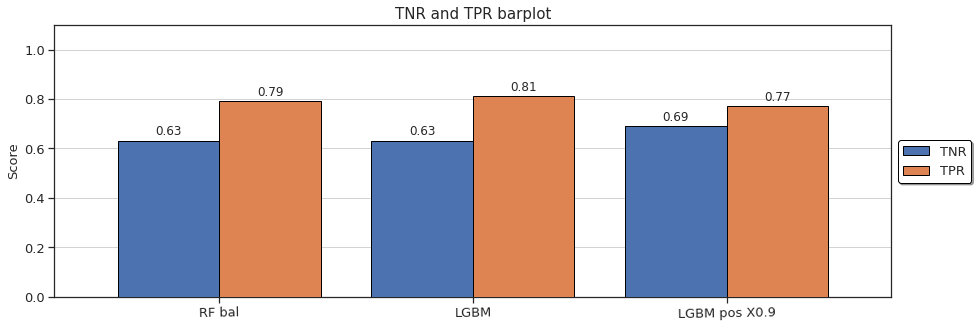

In [40]:
# Barplot of TNR and TPR
def get_tnr_tpr(ml_output):
  cf_matrix = confusion_matrix(ml_output["ytrue"], ml_output["ypred"])
  group_counts = [f"{value}" for value in cf_matrix.flatten()]
  row_sums = cf_matrix.sum(axis=1)
  norm_matrix = cf_matrix / row_sums[:, np.newaxis]
  group_percentages = [round(value, 2) for value in norm_matrix.flatten()]
  tnr, tpr = group_percentages[0], group_percentages[3]
  return tnr, tpr

def get_tnr_tpr_lst(ml_output_lst):
  lst_tnr, lst_tpr = [], []
  for ml_output in ml_output_lst: 
    tnr, tpr = get_tnr_tpr(ml_output)
    lst_tnr.append(tnr)
    lst_tpr.append(tpr)
  return lst_tnr, lst_tpr


def plot_tp_tn(val_output_lst, names, 
              bbox_to_anchor=(1.03, 0.6), annotation_size=13, 
                 save=False):
  # Group by metrics
  tnr, tpr = get_tnr_tpr_lst(val_output_lst)
  # Plot
  metric_df = pd.DataFrame({"TNR": tnr, "TPR": tpr}, index = names)
  ax = metric_df.plot(y=["TNR", "TPR"], 
                      ylim=(0,1.1), figsize=(15,5), fontsize=13, kind="bar", zorder=3, ec ="black",
                      rot=1, width=0.8)
  # Add details
  plt.title("TNR and TPR barplot", fontsize = 15)
  plt.ylabel("Score", fontsize = 13)
  plt.grid(axis="y", zorder=0, color="lightgray")  
  legend = plt.legend(frameon = 1, shadow = True, bbox_to_anchor=bbox_to_anchor, fontsize=13)
  frame = legend.get_frame()
  frame.set_facecolor('white')
  frame.set_edgecolor('black')
  # Annotate scores on top of the bars
  for p in ax.patches:
    height = p.get_height()
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    xpos='center'
    offset = {'center': 0, 'right': 1, 'left': -1}
    ax.annotate(f"{height:.2}",
                xy=(p.get_x() + p.get_width() / 2, height),
                xytext=(offset[xpos]*3, 3),  
                textcoords="offset points",  
                ha=ha[xpos], va='bottom', size=annotation_size)
  if save:
    plt.savefig(f"{DIRECTORY}tnr_tpr_barplot_{FILENAME}.png", 
                dpi = 300, bbox_extra_artists=(legend,), bbox_inches='tight')
  plt.show()


plot_tp_tn(val_output_lst, names, bbox_to_anchor=(1, 0.6), annotation_size=12, save=True)    
  